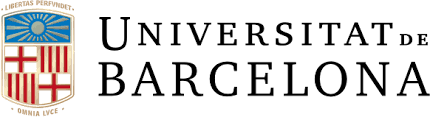

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training_Bin'
test_dir = '/content/drive/MyDrive/Testing_Bin'

In [4]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [5]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 4570 files for training.


In [6]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 1142 files for validation.


In [7]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['Notumor', 'Tumor']


**Visualizacion de algunas imagenes**

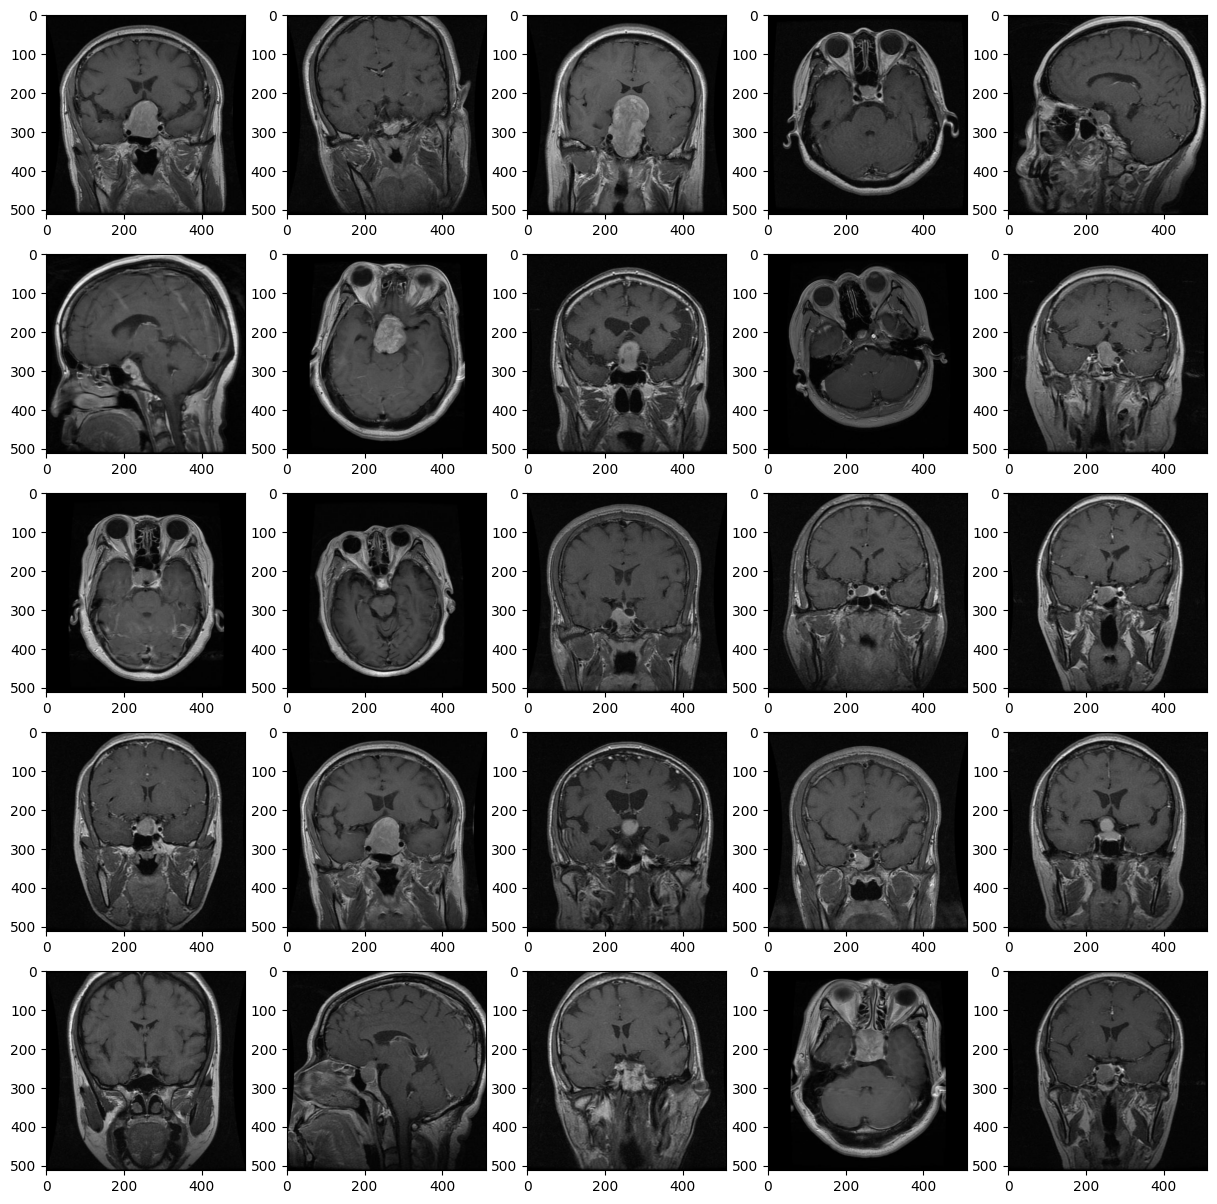

In [8]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Tumor'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training_Bin/Tumor'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [10]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [11]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

  ]
)

**Visualizacion de Imagenes despues de Data Augmentation**

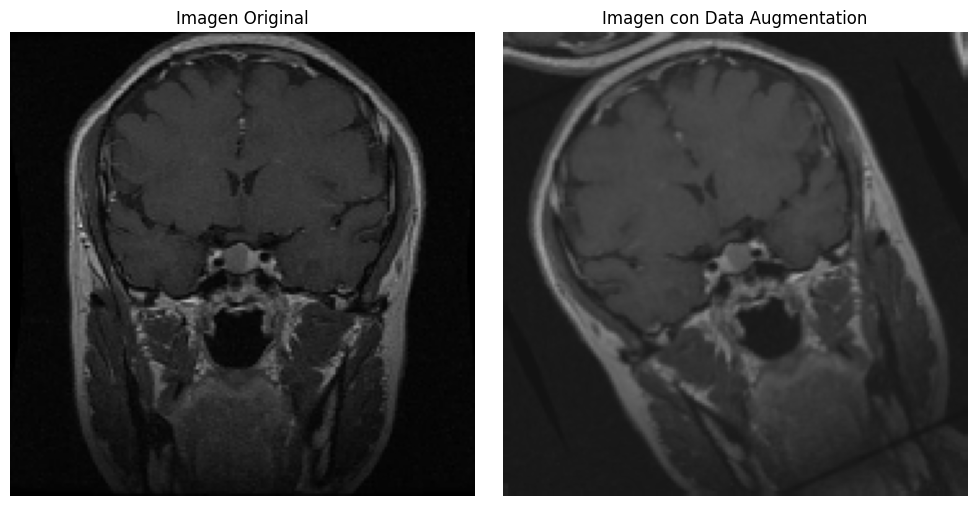

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config

# Habilitar el comportamiento de numpy en TensorFlow
np_config.enable_numpy_behavior()

# Obtener una imagen al azar del conjunto de entrenamiento
random_class = random.choice(class_names)
random_class_dir = os.path.join(train_dir, random_class)
random_image_path = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image_path)

# Cargar la imagen original y redimensionarla
image = load_img(image_path, target_size=(img_height, img_width))
image_array = img_to_array(image)

# Aplicar data augmentation a la imagen
augmented_image_array = data_augmentation(np.expand_dims(image_array, 0))
augmented_image = augmented_image_array[0]

# Normalizar los valores de píxeles al rango [0, 1]
image_array /= 255.0
augmented_image /= 255.0

# Mostrar la imagen original y la imagen con data augmentation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array)
axes[0].set_title("Imagen Original")
axes[0].axis("off")
axes[1].imshow(augmented_image)
axes[1].set_title("Imagen con Data Augmentation")
axes[1].axis("off")

plt.tight_layout()
plt.show()





**Resumen de Transformaciones usadas durante Data Augmentation**

In [13]:
print(data_augmentation.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 180, 180, 3)      0         
 ightness)                                                       
                                                        

# Entrenamiento del Modelo

In [14]:
# Cracion del modelo con Redes Neuronales Convolucionales (CNN)
num_classes = len(class_names)

from tensorflow.keras.layers import Dropout

model_with_dropout = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Capa de dropout
    layers.Dense(num_classes)#, activation='sigmoid')  # Cambiamos a sigmoid
])



In [15]:
# Compilar
model_with_dropout.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Cambio en la función de pérdida
             metrics=['accuracy'])



In [16]:
model_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [17]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNN_Bin.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

## Verificamos si hay una GPU Disponible para entrenar nuestro modelo

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib


In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Configura la GPU para el crecimiento de la memoria si es necesario
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    # Imprime información sobre las GPUs disponibles
    print("GPU(s) disponibles:")
    for gpu in gpus:
        print(gpu)
else:
    print("No se encontraron GPUs.")


Physical devices cannot be modified after being initialized
GPU(s) disponibles:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [20]:
epochs = 30
history = model_with_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNN.h5" en el directorio actual
model_with_dropout.save("TFM_CNNv_Bin.h5")

Epoch 1/30
143/143 [==============================] - 576s 839ms/step - loss: 0.4588 - accuracy: 0.8171 - val_loss: 0.2515 - val_accuracy: 0.8984
Epoch 2/30
143/143 [==============================] - 5s 35ms/step - loss: 0.2390 - accuracy: 0.9105 - val_loss: 0.2477 - val_accuracy: 0.8923
Epoch 3/30
143/143 [==============================] - 5s 33ms/step - loss: 0.2107 - accuracy: 0.9267 - val_loss: 0.1686 - val_accuracy: 0.9422
Epoch 4/30
143/143 [==============================] - 5s 32ms/step - loss: 0.1812 - accuracy: 0.9407 - val_loss: 0.2192 - val_accuracy: 0.9186
Epoch 5/30
143/143 [==============================] - 4s 31ms/step - loss: 0.1627 - accuracy: 0.9475 - val_loss: 0.1486 - val_accuracy: 0.9545
Epoch 6/30
143/143 [==============================] - 5s 33ms/step - loss: 0.1508 - accuracy: 0.9508 - val_loss: 0.1414 - val_accuracy: 0.9501
Epoch 7/30
143/143 [==============================] - 5s 32ms/step - loss: 0.1460 - accuracy: 0.9545 - val_loss: 0.1277 - val_accuracy: 0.9

# Curvas de Rendimiento

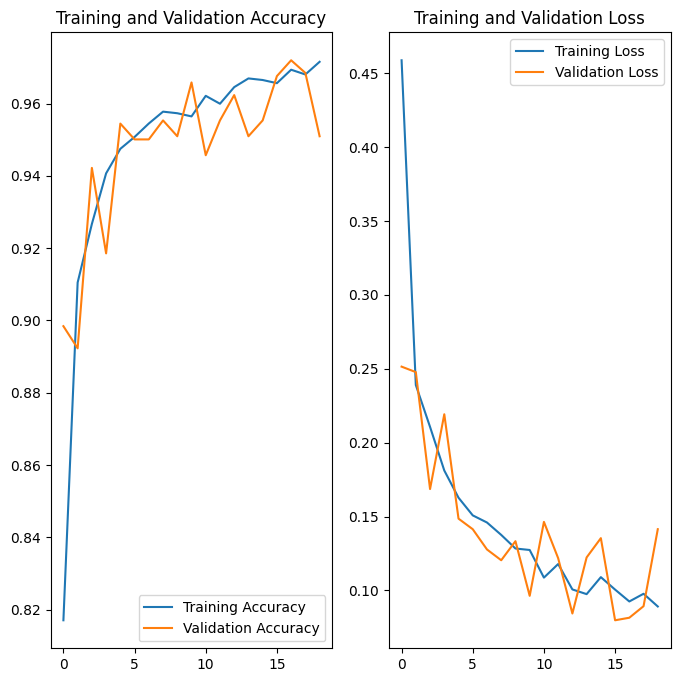

In [21]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Obtener las etiquetas reales del conjunto de pruebas
y_test_actual = np.array([])
for _, y in val_ds:
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))


1/1 [==============================] - 0s 124ms/step


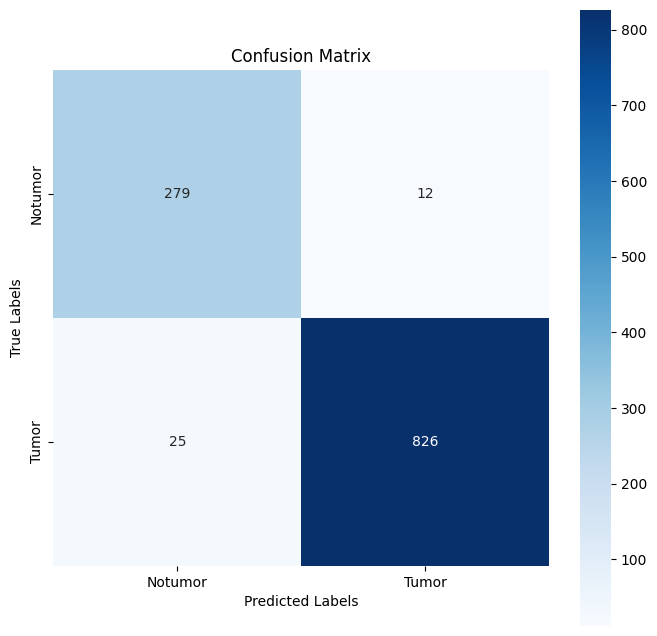

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar predicciones en el conjunto de pruebas
y_pred_actual = np.array([])
for x, _ in val_ds:
    predictions = model_with_dropout.predict(x)
    normalized_predictions = tf.nn.softmax(predictions)  # Aplicacion de softmax para obtener probabilidades
    y_pred = np.argmax(normalized_predictions, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

# matriz de confusión
conf_matrix = confusion_matrix(y_test_actual, y_pred_actual)

# Visualizacion de la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()




In [24]:
from sklearn.metrics import classification_report

# Obtener el informe de clasificación
report = classification_report(y_test_actual, y_pred_actual, target_names=class_names)

# Imprimir el informe
print(report)


              precision    recall  f1-score   support

     Notumor       0.92      0.96      0.94       291
       Tumor       0.99      0.97      0.98       851

    accuracy                           0.97      1142
   macro avg       0.95      0.96      0.96      1142
weighted avg       0.97      0.97      0.97      1142



## Lift chart